## Importing Necessary Libraries


In [ ]:
import pandas as pd

# visualization libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import folium
from folium import plugins

# Manipulating the default plot size
plt.rcParams['figure.figsize'] = 10,12
# Disable Warnings
import warnings
warnings.filterwarnings('ignore')

## Data Preprocessing

In [ ]:
# Reading the dataset
df1 = pd.read_csv('/content/COVID-19 Cases(19-11-2021).csv')
df = df1.copy()
df.head(8)

,S. No.,Date,Region,Confirmed Cases,Active Cases,Cured/Discharged,Death
0,1,01-01-1970,India,34260470,161555.0,33641175.0,457740.0
1,2,12-03-2020,India,74,71.0,3.0,0.0
2,3,13-03-2020,India,75,71.0,3.0,1.0
3,4,14-03-2020,India,84,72.0,10.0,2.0
4,5,15-03-2020,India,107,95.0,10.0,2.0
5,6,16-03-2020,India,114,99.0,13.0,2.0
6,7,17-03-2020,India,137,120.0,14.0,3.0
7,8,18-03-2020,India,146,129.0,14.0,3.0


Under region there is India. Why is India under regions when this was supposed to be state data ? Will do a further analysis on this. Also I will find out the shape of our data and the datatypes present in it.


In [ ]:
df.shape

(22305, 7)

In [ ]:
df.columns

Index(['S. No.', 'Date', 'Region', 'Confirmed Cases', 'Active Cases',
       'Cured/Discharged', 'Death'],
      dtype='object')

In [ ]:
# try to understand each column
# drop s.no
df.drop(columns = ['S. No.'], axis = 1, inplace = True)

In [ ]:
df.dtypes

Date                 object
Region               object
Confirmed Cases       int64
Active Cases        float64
Cured/Discharged    float64
Death               float64
dtype: object

In [ ]:
df[df['Region'] == 'India'].shape

(600, 6)

We can infer that Region = India gives us the sum of cases of all states ie national count of cases with time. 
I want to check whether each state has cases measured for the same time period.
I will check the number of rows for each state's cases to verify this.

In [ ]:
print('For Rajasthan:', df[df['Region'] == 'Rajasthan'].shape)
print('For Meghalaya:', df[df['Region'] == 'Meghalaya'].shape)


For Rajasthan: (600, 6)
For Meghalaya: (566, 6)


It was same for Rajasthan and the national figure but different from Meghalaya. So its not necessary that cases have been measured for same dates.

## Data Cleaning
### Null Values Imputation

In [ ]:
df.isnull().sum()

Date                  0
Region                0
Confirmed Cases       0
Active Cases        609
Cured/Discharged    610
Death                 1
dtype: int64

In [ ]:
# look deeper into null values
df[df['Active Cases'].isnull()]

,Date,Region,Confirmed Cases,Active Cases,Cured/Discharged,Death
21696,01-01-1970,World,245373039,NaN,NaN,4979421.0
21697,12-03-2020,World,129149,NaN,NaN,4724.0
21698,13-03-2020,World,138704,NaN,NaN,5085.0
21699,14-03-2020,World,149469,NaN,NaN,5553.0
21700,15-03-2020,World,161291,NaN,NaN,6003.0
...,...,...,...,...,...,...
22300,08-11-2021,World,249743428,NaN,NaN,5047652.0
22301,10-11-2021,World,250715502,NaN,NaN,5062106.0
22302,11-11-2021,World,251266207,NaN,NaN,5070244.0
22303,12-11-2021,World,251788329,NaN,NaN,5077907.0


In [ ]:
df[df['Region'] == 'World'].shape

(609, 6)

In [ ]:
df_active_null = df[df.isnull()]
df_active_null['Region'].nunique()

0

All null values for active cases come from world count of cases. Instead of dropping we will just leave out these rows while selecting our new dataframe.

In [ ]:
df[df['Cured/Discharged'].isnull()]

,Date,Region,Confirmed Cases,Active Cases,Cured/Discharged,Death
18065,03-04-2020,State assignment pending,18,18.0,NaN,NaN
21696,01-01-1970,World,245373039,NaN,NaN,4979421.0
21697,12-03-2020,World,129149,NaN,NaN,4724.0
21698,13-03-2020,World,138704,NaN,NaN,5085.0
21699,14-03-2020,World,149469,NaN,NaN,5553.0
...,...,...,...,...,...,...
22300,08-11-2021,World,249743428,NaN,NaN,5047652.0
22301,10-11-2021,World,250715502,NaN,NaN,5062106.0
22302,11-11-2021,World,251266207,NaN,NaN,5070244.0
22303,12-11-2021,World,251788329,NaN,NaN,5077907.0


In [ ]:
df_discharged_null = df[df['Cured/Discharged'].isnull()] 
df_discharged_null['Region'].value_counts()

World                       609
State assignment pending      1
Name: Region, dtype: int64

In [ ]:
# convert the date column to datetime object
df['Date_converted'] = pd.to_datetime(df.Date, dayfirst = True)

In [ ]:
df['Date_converted'].dtype

dtype('<M8[ns]')

### Coverting String Date to Datetime format

In [ ]:
df['year'] = pd.DatetimeIndex(df['Date_converted']).year
df['month'] = pd.DatetimeIndex(df['Date_converted']).month

In [ ]:
df.head()

,Date,Region,Confirmed Cases,Active Cases,Cured/Discharged,Death,Date_converted,year,month
0,01-01-1970,India,34260470,161555.0,33641175.0,457740.0,1970-01-01,1970,1
1,12-03-2020,India,74,71.0,3.0,0.0,2020-03-12,2020,3
2,13-03-2020,India,75,71.0,3.0,1.0,2020-03-13,2020,3
3,14-03-2020,India,84,72.0,10.0,2.0,2020-03-14,2020,3
4,15-03-2020,India,107,95.0,10.0,2.0,2020-03-15,2020,3


I will divide my dataframe into three parts, one only with states, one for the entire country and one for the world. So now I have three different dataframes for three different analysis

### Dividing Dataset into 3 separate Data Frames

In [ ]:
df_states = df[(df['Region'] != 'India') & (df['Region'] != 'World')]
df_india = df[df['Region'] == 'India']
df_world = df[df['Region'] == 'World']

### State Covid Data 

In [ ]:
df_states

,Date,Region,Confirmed Cases,Active Cases,Cured/Discharged,Death,Date_converted,year,month
600,01-01-1970,Andaman and Nicobar Islands,7651,5.0,7517.0,129.0,1970-01-01,1970,1
601,27-03-2020,Andaman and Nicobar Islands,1,1.0,0.0,0.0,2020-03-27,2020,3
602,28-03-2020,Andaman and Nicobar Islands,6,6.0,0.0,0.0,2020-03-28,2020,3
603,29-03-2020,Andaman and Nicobar Islands,9,9.0,0.0,0.0,2020-03-29,2020,3
604,30-03-2020,Andaman and Nicobar Islands,9,9.0,0.0,0.0,2020-03-30,2020,3
...,...,...,...,...,...,...,...,...,...
21691,12-11-2021,West Bengal,1601586,7973.0,1574333.0,19280.0,2021-11-12,2021,11
21692,14-11-2021,West Bengal,1603318,8031.0,1575980.0,19307.0,2021-11-14,2021,11
21693,15-11-2021,West Bengal,1604193,8062.0,1576817.0,19314.0,2021-11-15,2021,11
21694,16-11-2021,West Bengal,1604975,8047.0,1577609.0,19319.0,2021-11-16,2021,11


In [ ]:
# the date 1/1/1970 in the rows could represent the sum we need of total cases for each state, we need to verify that
df_states[df_states['Date_converted'] == '1970-01-01'].head()


,Date,Region,Confirmed Cases,Active Cases,Cured/Discharged,Death,Date_converted,year,month
600,01-01-1970,Andaman and Nicobar Islands,7651,5.0,7517.0,129.0,1970-01-01,1970,1
1185,01-01-1970,Andhra Pradesh,2065716,4837.0,2046512.0,14367.0,1970-01-01,1970,1
1785,01-01-1970,Arunachal Pradesh,55143,108.0,54755.0,280.0,1970-01-01,1970,1
2363,01-01-1970,Assam,610150,3791.0,600367.0,5992.0,1970-01-01,1970,1
2942,01-01-1970,Bihar,726085,45.0,716379.0,9661.0,1970-01-01,1970,1


In [ ]:
df_state_tot = df_states[df_states['Date_converted'] == '1970-01-01']
df_state_tot.rename(columns = {'Region': 'Name of State / UT'}, inplace = True)
df_state_tot.head()

,Date,Name of State / UT,Confirmed Cases,Active Cases,Cured/Discharged,Death,Date_converted,year,month
600,01-01-1970,Andaman and Nicobar Islands,7651,5.0,7517.0,129.0,1970-01-01,1970,1
1185,01-01-1970,Andhra Pradesh,2065716,4837.0,2046512.0,14367.0,1970-01-01,1970,1
1785,01-01-1970,Arunachal Pradesh,55143,108.0,54755.0,280.0,1970-01-01,1970,1
2363,01-01-1970,Assam,610150,3791.0,600367.0,5992.0,1970-01-01,1970,1
2942,01-01-1970,Bihar,726085,45.0,716379.0,9661.0,1970-01-01,1970,1


Upon comparing with the actual data i figured out these are the cumulative values over the time period from which the data was taken uptill 25 September 2021.

**Data Visualization**

## Visualizing Total Covid Cases on the Map of India

In [ ]:
#@title
# coordinates of India states and union territories
india_coord = pd.read_excel('/content/Indian Coordinates.xlsx')

In [ ]:
#@title
df_full = pd.merge(india_coord, df_state_tot, on = 'Name of State / UT')
map = folium.Map(location = [20,70], zoom_start=4, tiles = 'Stamenterrain')

for lat, lon, value, name in zip(df_full['Latitude'], df_full['Longitude'], df_full['Confirmed Cases'], df_full['Name of State / UT']):
    folium.CircleMarker([lat, lon], radius = value/100000, color = 'crimson', fill_color='red', ).add_to(map)

map

In [ ]:
#@title
df_full.shape

(15, 11)

In [ ]:
#@title
df_full.head()

,Name of State / UT,Latitude,Longitude,Date,Confirmed Cases,Active Cases,Cured/Discharged,Death,Date_converted,year,month
0,Andaman and Nicobar Islands,11.667026,92.735983,01-01-1970,7651,5.0,7517.0,129.0,1970-01-01,1970,1
1,Andhra Pradesh,14.750429,78.570026,01-01-1970,2065716,4837.0,2046512.0,14367.0,1970-01-01,1970,1
2,Dadra and Nagar Haveli and Daman and Diu,20.266578,73.016618,01-01-1970,10682,6.0,10672.0,4.0,1970-01-01,1970,1
3,Delhi,28.669993,77.230004,01-01-1970,1439788,334.0,1414363.0,25091.0,1970-01-01,1970,1
4,Gujarat,22.258700,71.192400,01-01-1970,826526,192.0,816246.0,10088.0,1970-01-01,1970,1


## Statewise Confirmed Vs Recovered Cases

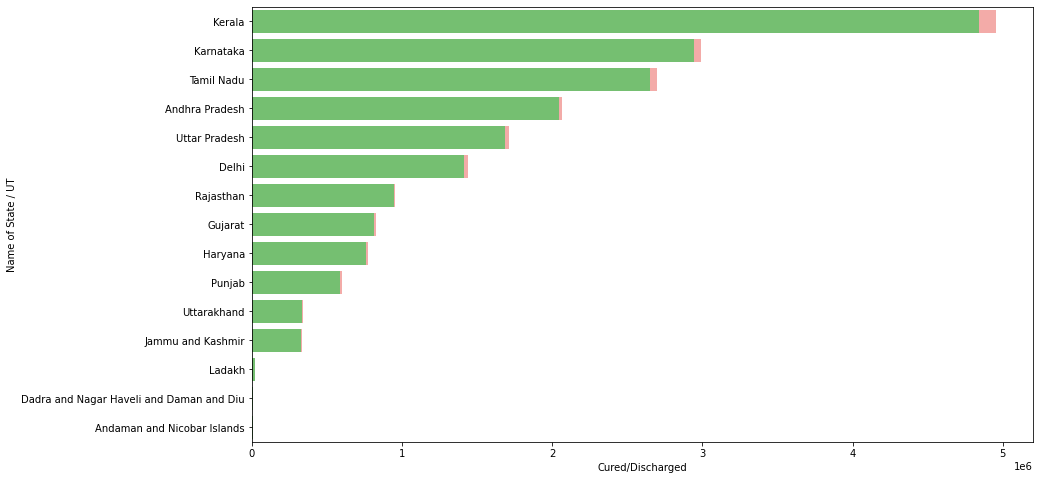

In [ ]:
#@title
## Confirmed vs Recovered Figures
fig, ax = plt.subplots(figsize = (14,8))
data = df_full[['Name of State / UT', 'Confirmed Cases', 'Cured/Discharged', 'Death']]
data.sort_values('Confirmed Cases', ascending = False, inplace = True)
sns.set_color_codes("pastel")
sns.barplot(x = 'Confirmed Cases', y = 'Name of State / UT', data = data, label = 'Total', color = 'r')

sns.set_color_codes('muted')
sns.barplot(x = 'Cured/Discharged', y = 'Name of State / UT', data = data, label = 'Cured', color = 'g')

## Total Number of Deaths Statewise

In [ ]:
#@title
table1 = df_state_tot[['Name of State / UT', 'Death', 'Active Cases']].sort_values(by = 'Death')
table1.head()

,Name of State / UT,Death,Active Cases
4717,Dadra and Nagar Haveli and Daman and Diu,4.0,6.0
11206,Lakshadweep,51.0,0.0
600,Andaman and Nicobar Islands,129.0,5.0
10606,Ladakh,208.0,58.0
1785,Arunachal Pradesh,280.0,108.0


Text(0.5, 1.0, 'Deaths per State')

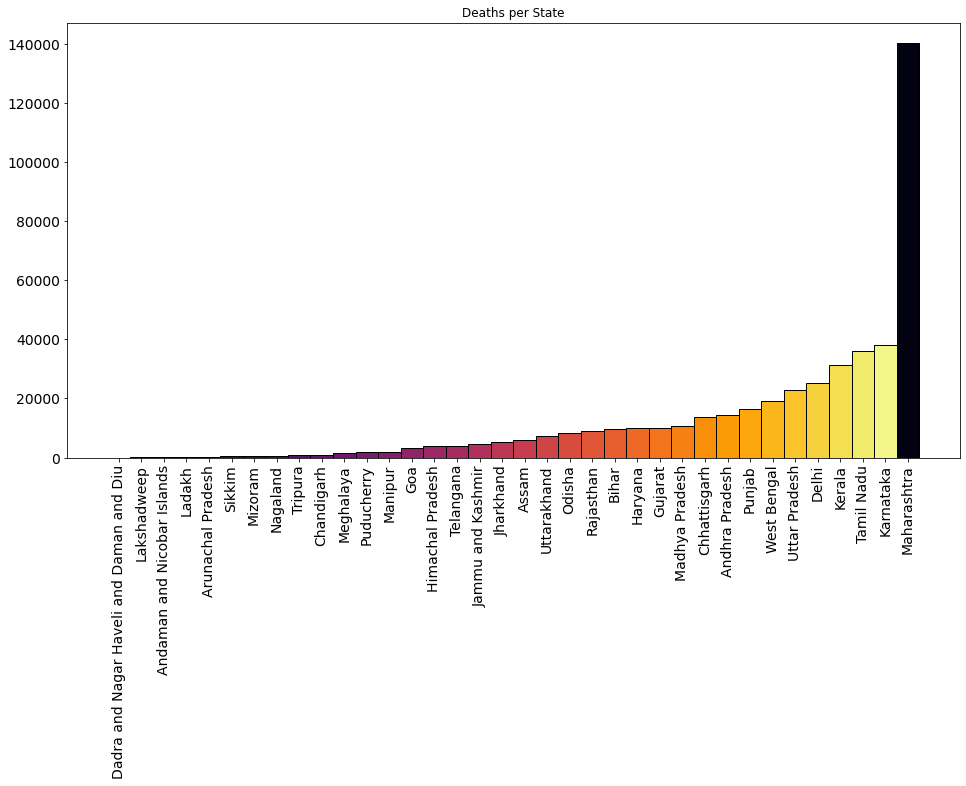

In [ ]:
#@title
plt.subplots(figsize = (16,8))
plt.bar(table1['Name of State / UT'], table1['Death'], width = 1, edgecolor = 'black', color = sns.color_palette('inferno', 35))
plt.xticks(rotation = 90, size = 14)
plt.yticks(size = 14)
plt.title('Deaths per State')

## Total Number of Active Cases Statewise

In [ ]:
#@title
table2 = table1.copy()
table2.sort_values(by = 'Active Cases', inplace = True)
table2.head()

,Name of State / UT,Death,Active Cases
11206,Lakshadweep,51.0,0.0
600,Andaman and Nicobar Islands,129.0,5.0
4717,Dadra and Nagar Haveli and Daman and Diu,4.0,6.0
16918,Rajasthan,8954.0,30.0
3532,Chandigarh,820.0,30.0


Text(0.5, 1.0, 'Deaths per State')

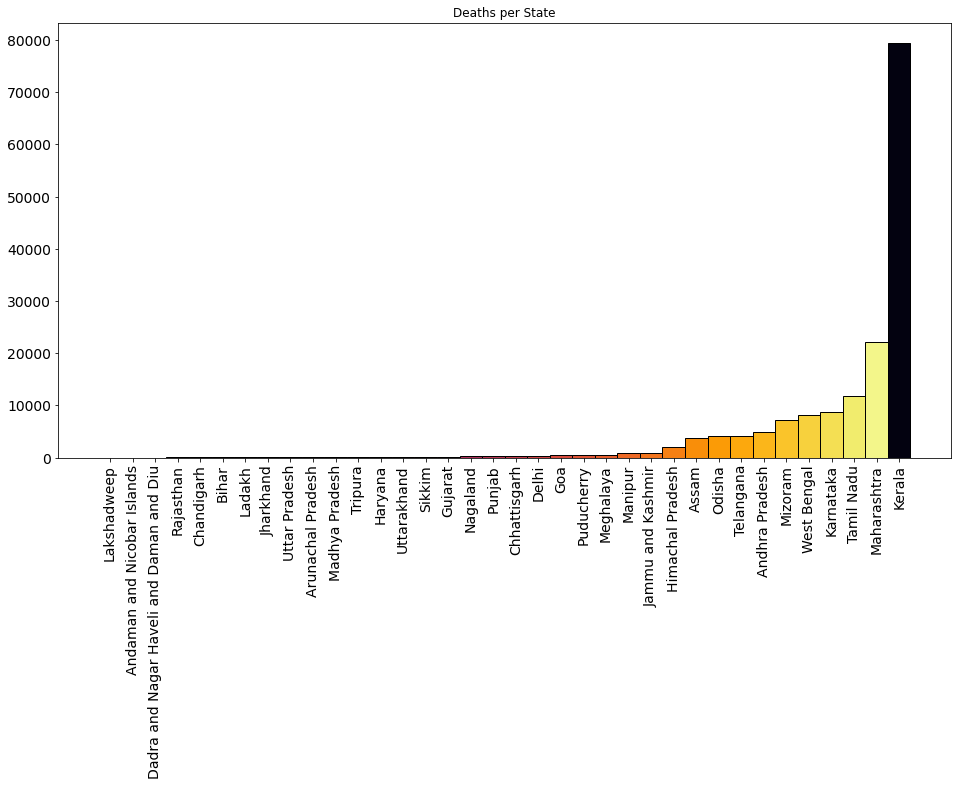

In [ ]:
#@title
plt.subplots(figsize = (16,8))
plt.bar(table2['Name of State / UT'], table2['Active Cases'], width = 1, edgecolor = 'black', color = sns.color_palette('inferno', 35))
plt.xticks(rotation = 90, size = 14)
plt.yticks(size = 14)
plt.title('Deaths per State')

## Rise in Total Deaths Across India

In [ ]:
df_india.head()

,Date,Region,Confirmed Cases,Active Cases,Cured/Discharged,Death,Date_converted,year,month
0,01-01-1970,India,34260470,161555.0,33641175.0,457740.0,1970-01-01,1970,1
1,12-03-2020,India,74,71.0,3.0,0.0,2020-03-12,2020,3
2,13-03-2020,India,75,71.0,3.0,1.0,2020-03-13,2020,3
3,14-03-2020,India,84,72.0,10.0,2.0,2020-03-14,2020,3
4,15-03-2020,India,107,95.0,10.0,2.0,2020-03-15,2020,3


In [ ]:
India_table = df_india[df_india['Date_converted'] != '1970-01-01']
India_table.head()

,Date,Region,Confirmed Cases,Active Cases,Cured/Discharged,Death,Date_converted,year,month
1,12-03-2020,India,74,71.0,3.0,0.0,2020-03-12,2020,3
2,13-03-2020,India,75,71.0,3.0,1.0,2020-03-13,2020,3
3,14-03-2020,India,84,72.0,10.0,2.0,2020-03-14,2020,3
4,15-03-2020,India,107,95.0,10.0,2.0,2020-03-15,2020,3
5,16-03-2020,India,114,99.0,13.0,2.0,2020-03-16,2020,3


In [ ]:
India_table.shape

(599, 9)

In [ ]:
df_india_tot = df_india[df_india['Date_converted'] == '1970-01-01']
df_india_tot.head()

,Date,Region,Confirmed Cases,Active Cases,Cured/Discharged,Death,Date_converted,year,month
0,01-01-1970,India,34260470,161555.0,33641175.0,457740.0,1970-01-01,1970,1


In [ ]:
df_india[df_india['Date_converted'] > '2021-10-01'].shape

(45, 9)

### Creating Data Frame for Delhi

In [ ]:
df_delhi = df_states[df_states['Region'] == 'Delhi']
df_delhi.drop(index = 5259, inplace = True)

In [ ]:
df_delhi.head()

,Date,Region,Confirmed Cases,Active Cases,Cured/Discharged,Death,Date_converted,year,month
5260,12-03-2020,Delhi,6,6.0,0.0,0.0,2020-03-12,2020,3
5261,13-03-2020,Delhi,6,6.0,0.0,0.0,2020-03-13,2020,3
5262,14-03-2020,Delhi,7,5.0,1.0,1.0,2020-03-14,2020,3
5263,15-03-2020,Delhi,7,4.0,2.0,1.0,2020-03-15,2020,3
5264,16-03-2020,Delhi,7,4.0,2.0,1.0,2020-03-16,2020,3


## Time Series Analysis

### Creating a univariate Time Series Data for Input

In [ ]:
df_input = df_delhi[['Date_converted', 'Confirmed Cases']]
df_input.rename(columns = {'Date_converted': 'ds', 'Confirmed Cases': 'y'}, inplace = True)
df_input.reset_index(inplace = True)
df_input.drop(columns = 'index', inplace = True)
df_input.head()

,ds,y
0,2020-03-12,6
1,2020-03-13,6
2,2020-03-14,7
3,2020-03-15,7
4,2020-03-16,7


In [ ]:
df_input.shape

(599, 2)

## PROPHET MODEL

### Forecasting Confirmed COVID-19 Cases for Delhi with Prophet (Base Model)

In [ ]:
from fbprophet import Prophet

To use Prophet for forecasting, first, a Prophet() object is defined and configured, then it is fit on the dataset by calling the fit() function and passing the data.

The Prophet() object takes arguments to configure the type of model you want, such as the type of growth, the type of seasonality, and more. By default, the model will work hard to figure out almost everything automatically.

The fit() function takes a DataFrame of time series data. The DataFrame must have a specific format. The first column must have the name ‘ds‘ and contain the date-times. The second column must have the name ‘y‘ and contain the observations.

**We will now fit the model onto the training set**

**We are using the Hold Out Validation technique where approximately 80 % of the data will be used for training and the rest 20% will be used to test the model on**.



In [ ]:
train = df_input.iloc[:int(df_input.shape[0]*0.80)]
test = df_input.iloc[int(df_input.shape[0]*0.80):]
print(train.shape, test.shape)

(479, 2) (120, 2)


In [ ]:
print(train.tail())

            ds        y
474 2021-07-09  1434873
475 2021-07-10  1434954
476 2021-07-11  1435030
477 2021-07-12  1435083
478 2021-07-13  1435128


In [ ]:
m = Prophet(interval_width=0.95)
m.fit(train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


A forecast is made by calling the predict() function and passing a DataFrame that contains one column named ‘ds‘ and rows with date-times for all the intervals to be predicted.

There are many ways to create this “forecast” DataFrame. In this case we will make it using the in built method.

**We will first call the predict method on the In Sample data or hold out validation set**


In [ ]:
# define the period for which we want a prediction
validation = test.drop(columns = ['y'])
print(validation.head(), validation.shape)

            ds
479 2021-07-14
480 2021-07-15
481 2021-07-16
482 2021-07-17
483 2021-07-18 (120, 1)


In [ ]:
# use the model to make a forecast
forecast = m.predict(validation)

In [ ]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-07-14,1.652607e+06,1.517552e+06,1.790965e+06,1.652607e+06,1.652672e+06,190.418815,190.418815,190.418815,190.418815,190.418815,190.418815,0.0,0.0,0.0,1.652798e+06
1,2021-07-15,1.660824e+06,1.532757e+06,1.785233e+06,1.660713e+06,1.661301e+06,1792.214780,1792.214780,1792.214780,1792.214780,1792.214780,1792.214780,0.0,0.0,0.0,1.662616e+06
2,2021-07-16,1.669040e+06,1.538633e+06,1.808590e+06,1.668351e+06,1.669906e+06,2910.757253,2910.757253,2910.757253,2910.757253,2910.757253,2910.757253,0.0,0.0,0.0,1.671951e+06
3,2021-07-17,1.677257e+06,1.542445e+06,1.805909e+06,1.676077e+06,1.678580e+06,-2447.756232,-2447.756232,-2447.756232,-2447.756232,-2447.756232,-2447.756232,0.0,0.0,0.0,1.674809e+06
4,2021-07-18,1.685474e+06,1.558592e+06,1.821934e+06,1.683615e+06,1.687502e+06,241.368308,241.368308,241.368308,241.368308,241.368308,241.368308,0.0,0.0,0.0,1.685715e+06


In [ ]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
115,2021-11-12,2.649721e+06,2.342171e+06,2.891538e+06
116,2021-11-14,2.663485e+06,2.351934e+06,2.962740e+06
117,2021-11-15,2.670738e+06,2.339845e+06,2.963630e+06
118,2021-11-16,2.677712e+06,2.365059e+06,2.975911e+06
119,2021-11-17,2.688084e+06,2.372476e+06,2.970890e+06


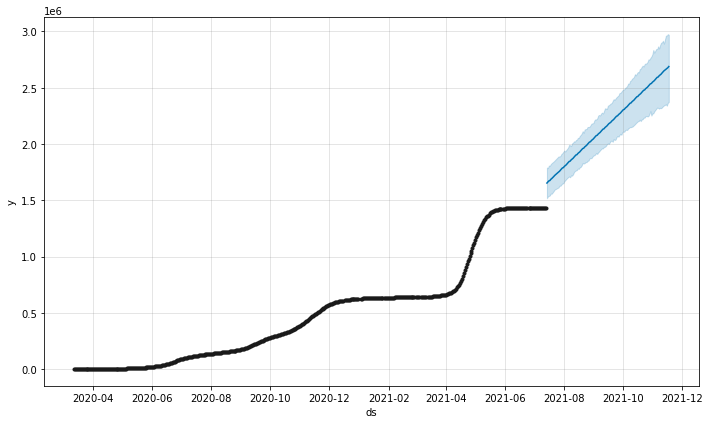

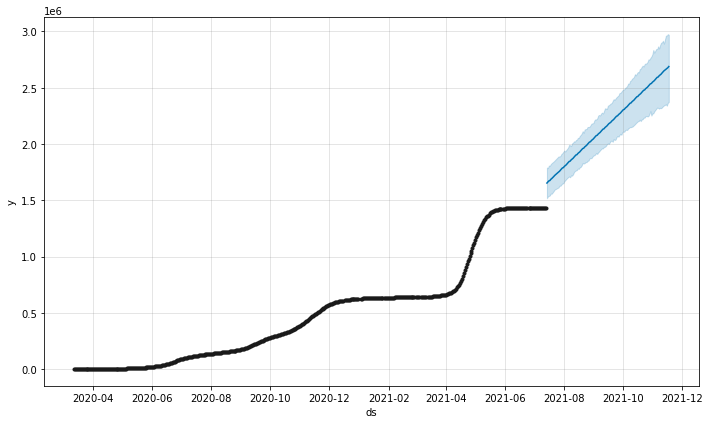

In [ ]:
m.plot(forecast)

**Testing Model Accuracy Using Various Metrics**

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

In [ ]:
# calculate MAE between expected and predicted values for december
y_true = test['y'].values
y_pred = forecast['yhat'].values
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print('The Mean Absolute Error for our Model is (MAE): %.3f' % mae)
print('The Root Mean Sqaured Error for our Model is (RMSE): %.3f' % rmse)

The Mean Absolute Error for our Model is (MAE): 739336.250
The Root Mean Sqaured Error for our Model is (RMSE): 794901.778


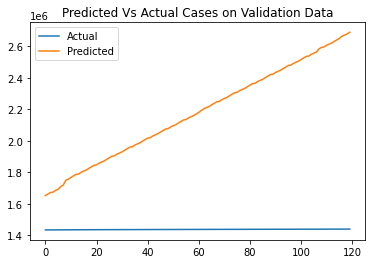

In [ ]:
# plot expected vs actual
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Predicted Vs Actual Cases on Validation Data')
plt.legend()
plt.show()

**Making Future Predictions on unseen data**
**These predictions are being made for one week ahead from the last date the COVID infection was reported**

In [ ]:
future = m.make_future_dataframe(periods = 150)
future.shape

(629, 1)

In [ ]:
future.head()

,ds
0,2020-03-12
1,2020-03-13
2,2020-03-14
3,2020-03-15
4,2020-03-16


In [ ]:
future.tail()

,ds
624,2021-12-06
625,2021-12-07
626,2021-12-08
627,2021-12-09
628,2021-12-10


In [ ]:

pd.set_option('display.float_format', lambda x: '%.5f' % x)

Let us plot the forecast by calling the Prophet.plot method and passing in our forecast dataframe.

In [ ]:

forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
619,2021-12-01,2803115.69559,2486328.59534,3116272.91183
620,2021-12-02,2812934.04834,2500901.54881,3155491.16205
621,2021-12-03,2822269.14759,2508160.96937,3165020.01904
622,2021-12-04,2825127.19088,2500341.48781,3154311.78020
623,2021-12-05,2836032.87220,2495600.91617,3170209.92578
624,2021-12-06,2843285.82170,2513801.32650,3206428.10695
625,2021-12-07,2850259.85350,2507396.30822,3215626.20347
626,2021-12-08,2860631.59304,2529719.46643,3240044.67593
627,2021-12-09,2870449.94579,2529617.67200,3248086.60225
628,2021-12-10,2879785.04504,2535124.48682,3244042.64026


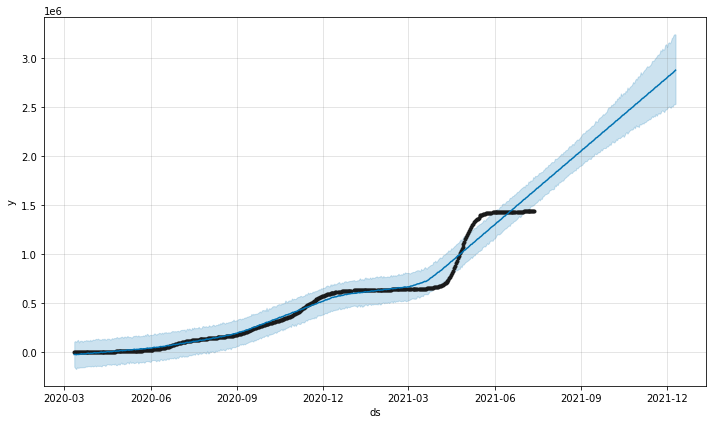

In [ ]:
confirmed_forecast_plot = m.plot(forecast)

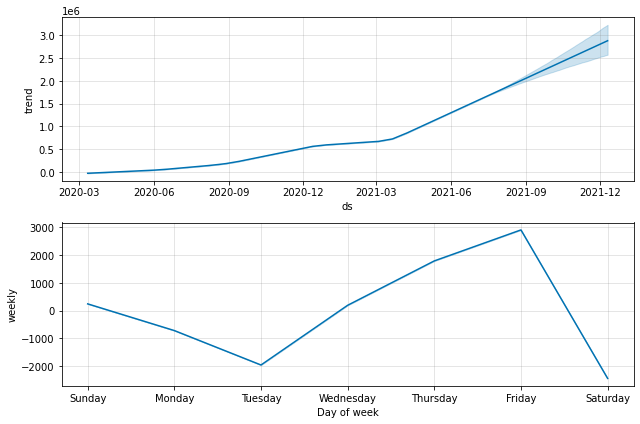

In [ ]:
confirmed_forecast_plot = m.plot_components(forecast)

## ARIMA MODEL

In [ ]:
df_input.set_index('ds',inplace=True)

In [ ]:
df_input.head()

,y
ds,
2020-03-12,6
2020-03-13,6
2020-03-14,7
2020-03-15,7
2020-03-16,7


## Visualizing the Data

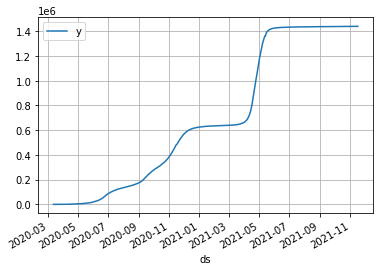

In [ ]:
df_input.plot(grid = True)

In [ ]:
rollmean = df_input.rolling(window = 30).mean()
rollstd = df_input.rolling(window = 30).std()

## Testing For Stationarity

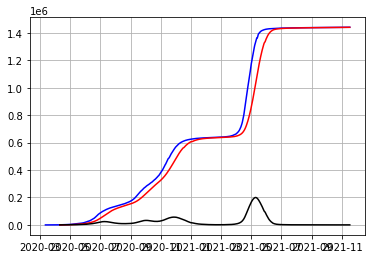

In [ ]:
plt.plot(df_input.index, df_input['y'], color = 'blue', label = 'original')
plt.grid()
plt.plot(rollmean, color = 'red', label = 'Rolling Mean')
plt.plot(rollstd, color = 'black', label = 'Rolling Deviation')


**By plotting the rolling mean and rolling deviation we can see that the data is non stationary. We will perform another test called as the Dicky Fuller Test to ascertain the same**

In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
test_result = adfuller(df_input['y'])

In [ ]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(y):
    result=adfuller(y)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    

In [ ]:
adfuller_test(df_input['y'])

ADF Test Statistic : -0.4998657801901546
p-value : 0.8920426860205182
#Lags Used : 15
Number of Observations Used : 583
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


**Plotting Log graph**

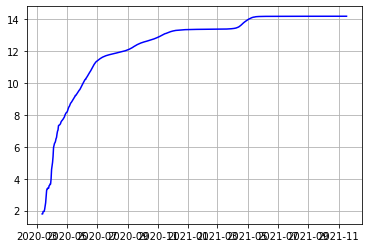

In [ ]:
log_scale = np.log(df_input)
plt.plot(log_scale, color = 'blue')
plt.grid()

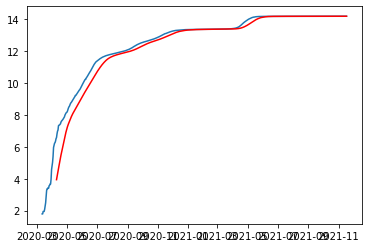

In [ ]:
movingAverage = log_scale.rolling(window = 30).mean()
movingStd = log_scale.rolling(window =30).std()
plt.plot(log_scale)
plt.plot(movingAverage, color = 'red')

**Transformation - 1: Log Scale Graph - Moving Average**

In [ ]:
logscaleminusmovingavg = log_scale - movingAverage
logscaleminusmovingavg.dropna(inplace = True)
logscaleminusmovingavg.head(10)

,y
ds,
2020-04-10,2.64139
2020-04-11,2.70073
2020-04-12,2.69673
2020-04-13,2.60307
2020-04-14,2.69281
2020-04-15,2.54579
2020-04-16,2.38047
2020-04-17,2.24901
2020-04-18,2.12380


In [ ]:
def teststationarity(timeseries):

  # Determine rolling statistics
  movingAverage = timeseries.rolling(window=30).mean()
  movingStd = timeseries.rolling(window=30).std()

  # Plot rolling statistics
  orig = plt.plot(timeseries, color = 'blue', label = 'Original')
  orig = plt.plot(movingAverage, color = 'red', label = 'Moving Average')
  orig = plt.plot(movingStd, color = 'black', label = 'Moving Standard Deviation')

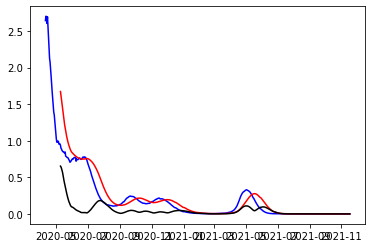

In [ ]:
teststationarity(logscaleminusmovingavg['y'])

In [ ]:
adfuller_test(logscaleminusmovingavg['y'])

ADF Test Statistic : -3.0143125672725812
p-value : 0.03357923309878203
#Lags Used : 19
Number of Observations Used : 550
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


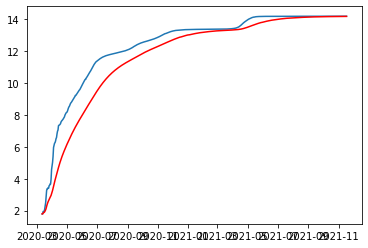

In [ ]:
exponentialdecayweightedavg = log_scale.ewm(halflife = 30, min_periods =0, adjust=True).mean()
plt.plot(log_scale)
plt.plot(exponentialdecayweightedavg, color = 'red')

**Transformation - 2: Log Scale Graph - Weighted Average**

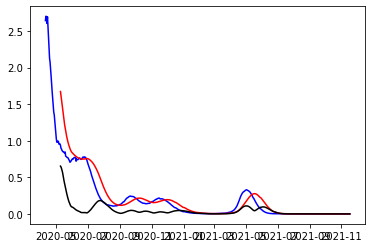

In [ ]:
logscaleminusweightedavg = log_scale - exponentialdecayweightedavg
teststationarity(logscaleminusmovingavg)

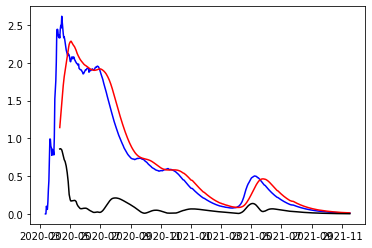

In [ ]:
teststationarity(logscaleminusweightedavg)

In [ ]:
adfuller_test(logscaleminusweightedavg['y'])

ADF Test Statistic : -1.3176173746859725
p-value : 0.6210742990126892
#Lags Used : 18
Number of Observations Used : 580
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


**Transformation - 3: Shifting and Subtracting the Log Scale Graph**

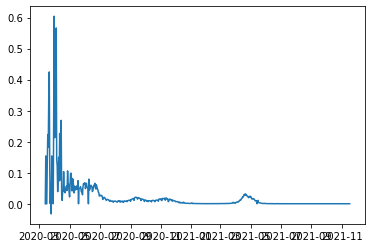

In [ ]:
logdifshifting = log_scale - log_scale.shift()
plt.plot(logdifshifting)

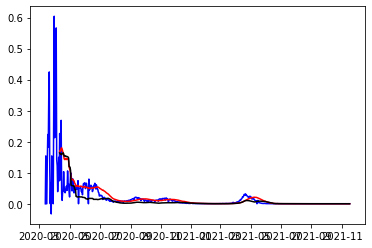

In [ ]:
logdifshifting.dropna(inplace = True)
teststationarity(logdifshifting)

In [ ]:
adfuller_test(logdifshifting['y'])

ADF Test Statistic : -8.28378253837957
p-value : 4.4467629353238153e-13
#Lags Used : 19
Number of Observations Used : 578
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


## ACF Plot

Text(0.5, 1.0, 'Partial Autocorrelation Function')

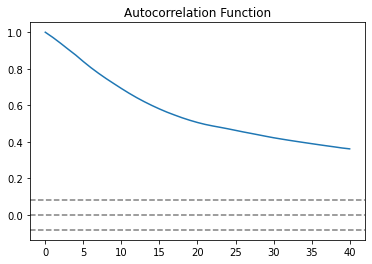

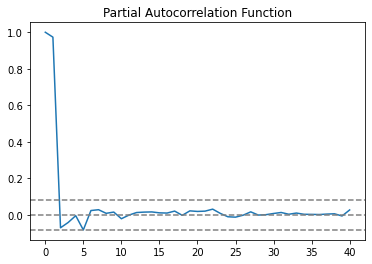

In [ ]:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(logscaleminusmovingavg)
lag_pacf = pacf(logscaleminusmovingavg)

# Plot ACF
plt.subplots()
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color = 'gray')
plt.axhline(y=-1.96/np.sqrt(len(logscaleminusmovingavg)), linestyle='--', color = 'gray')
plt.axhline(y=1.96/np.sqrt(len(logscaleminusmovingavg)), linestyle='--', color = 'gray')
plt.title('Autocorrelation Function')

# Plot PACF
plt.subplots()
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color = 'gray')
plt.axhline(y=-1.96/np.sqrt(len(logscaleminusmovingavg)), linestyle='--', color = 'gray')
plt.axhline(y=1.96/np.sqrt(len(logscaleminusmovingavg)), linestyle='--', color = 'gray')
plt.title('Partial Autocorrelation Function')


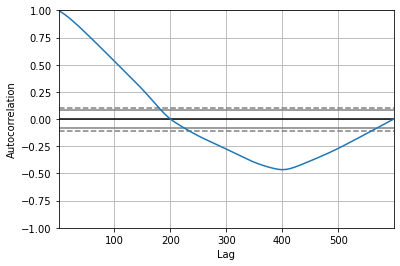

In [ ]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df_input)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



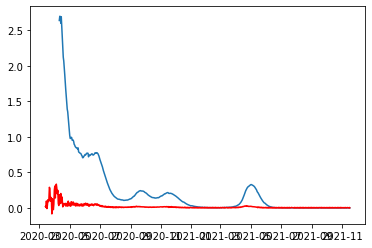

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

# AR Model
model = ARIMA(log_scale, order = (3,1,4))
results_AR = model.fit(disp = 1)
plt.plot(logscaleminusmovingavg)
plt.plot(results_AR.fittedvalues, color = 'red')

In [ ]:
pip install pmdarima

     |████████████████████████████████| 1.4 MB 5.2 MB/s 
     |████████████████████████████████| 9.8 MB 41.7 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
pip install statsmodels

In [ ]:
import pmdarima as pmd

def arimamodel(timeseries):
    autoarima_model = pmd.auto_arima(timeseries, 
                              start_p=1, 
                              start_q=1,
                              test="adf",
                              trace=True)
    return autoarima_model

ImportError: ignored

In [ ]:
arima_model = arimamodel(df_input)
arima_model.summary()

## Holts Model For Time Series Prediction

In [ ]:
from statsmodels.tsa.api import Holt

In [ ]:
df_input.head()

**We will now divide our Training data into Train and Validation samples. The training has been performed using 80 % of the dataset and the rest 20 % was kept for testing. The size has been kept same as was the case in Prohpeht Model**

In [ ]:
train_data = df_input.iloc[:int(df_input.shape[0]*0.80)]
test_data = df_input.iloc[int(df_input.shape[0]*0.80):]

In [ ]:
print(train_data.shape, test_data.shape)

In [ ]:
fitted_model = Holt(train_data['y']).fit(smoothing_level=1.4, smoothing_slope=0.2)


In [ ]:
print(fitted_model.summary())

In [ ]:
test_predictions = fitted_model.predict(600)

In [ ]:
test_predictions.tail()